In [1]:
import os            # для работы с операционной системой
import pickle        # для сохранения и загрузки переменных
import pandas as pd  # для работы с таблицами
import numpy  as np  # для работы с массивами
import re            # для работы с регулярными выражениями
import zlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

import tensorflow as tf
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam, Adadelta, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Заполнение последовательностей до определенной длины
import matplotlib.pyplot as plt
#from sklearn.feature_extraction.text import TfidfVectorizer
# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка датафрейма
# with open( 'total_transcriptions_text_df.pkl', 'rb') as f:
#    df = pkl.load(f)
#f_dir = '/content/drive/MyDrive/Traineeships/media108/'
f_dir = 'c:/Users/vokulovskiy/Documents/python/media108/'
f_name = 'df_new_good.xlsx'
f_name_mod = 'df_new_good_mod1.xlsx'
f_name_mod_csv = 'df_new_good_mod1.csv'
#df = pd.read_excel(f_dir+f_name_mod)
df = pd.read_csv(f_dir+f_name_mod_csv, sep=';') # ,encoding='cp1251'
#df = pd.read_csv(f_name)
#df.to_excel('f_dir+f_name', index=False)

# Подготовка данных

In [ ]:
# оставим поля Name, Текст_whisper, Дата и время, Длительность звонка, Номер обращения, Признак, Теги
new_col = {'Текст_whisper':'text','Дата и время':'date_time','Длительность звонка':'length','Номер обращения':'ref_num','Name':'name','Теги':'tags','Признак':'target'}
df.rename(columns = new_col, inplace=True)
df = df.loc[:,list(new_col.values())]
#Удаляем из Текст_whisper все символы кроме русских букв и цифр
df.text = df.text.apply(lambda s: re.sub("[^А-Яа-я0-9 ]", "", s.lower()).strip())
# Заменим буквы 'ё' на 'е'
df.text = df.text.str.replace('ё', 'е', regex=False)
# удаляем строки с пустым текстом
df = df[df.text.str.len()>0]
# поменяем тип столбца с датами
df.date_time = pd.to_datetime(df.date_time, format='%Y-%m-%d %H:%M:%S')
# Сколько целевых звонков длиной меньше х сек?
for x in range(30,76,5):
    print(f'Целевых звонков с длительностью < {x} сек: {df[(df.length<x)&(df.target==1)].target.count()}, всего звонков {df[df.length<x].target.count()}')
# Целевых звонков с длительностью < 30 сек: 2, всего звонков 1737
# Удаляем звонки с длительностью < 30 сек
df = df[(df.length>30)]
print(df.target.value_counts())

# 0    2528
# 1    2263

Целевых звонков с длительностью < 30 сек: 0, всего звонков 0
Целевых звонков с длительностью < 35 сек: 11, всего звонков 122
Целевых звонков с длительностью < 40 сек: 22, всего звонков 261
Целевых звонков с длительностью < 45 сек: 40, всего звонков 383
Целевых звонков с длительностью < 50 сек: 53, всего звонков 516
Целевых звонков с длительностью < 55 сек: 68, всего звонков 628
Целевых звонков с длительностью < 60 сек: 81, всего звонков 759
Целевых звонков с длительностью < 65 сек: 95, всего звонков 867
Целевых звонков с длительностью < 70 сек: 109, всего звонков 966
Целевых звонков с длительностью < 75 сек: 123, всего звонков 1090
target
0    2528
1    2263
Name: count, dtype: int64


'\n0    2528\n1    2263'

In [ ]:
# Добавление колонки "Признак" и заполнение ее данными на основе колоки "Теги"
#df.insert(7,'target1',value=np.NaN)
list_teg = df.tags.str.strip().tolist()
list_priz = []
for i in range(len(list_teg)):
    list_priz.append(1 if (re.search(r'\bПервичный целевой\b',list_teg[i],re.I) != None or re.search(r'\bЦелевой_М108',list_teg[i]) != None) else 0)
    if (re.search(r'\b[Нн]ецелевой\b',list_teg[i],re.I) != None or re.search(r'\b[нН]ецелевой_',list_teg[i]) != None):
        list_priz[i] = 0
df.target1 = list_priz

In [ ]:
#df[df.tags.str.contains('торичный целевой') & ~df.tags.str.contains('остпродажное обслуживание')].tags
#df[df.tags.str.contains('повторная покупка')].tags

In [ ]:
# df.sample(5)
df.info()
df.columns
# df.nunique()
# df.to_excel(f_dir+f_name_mod, index=False)
# df.target.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       4791 non-null   object
 1   date_time  4791 non-null   object
 2   length     4791 non-null   int64 
 3   ref_num    4791 non-null   int64 
 4   name       4791 non-null   object
 5   tags       4791 non-null   object
 6   target     4791 non-null   int64 
 7   text_bow   4791 non-null   object
 8   text_emb   4791 non-null   object
dtypes: int64(3), object(6)
memory usage: 337.0+ KB


Index(['text', 'date_time', 'length', 'ref_num', 'name', 'tags', 'target',
       'text_bow', 'text_emb'],
      dtype='object')

In [ ]:
df.drop(['text', 'date_time', 'length', 'ref_num', 'name', 'tags'],axis=1, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4791 entries, 0 to 4790
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   target    4791 non-null   int64 
 1   text_bow  4791 non-null   object
 2   text_emb  4791 non-null   object
dtypes: int64(1), object(2)
memory usage: 112.4+ KB


In [ ]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_features = vectorizer.fit_transform(df.text).toarray()
tfidf_features.shape
# Мешок слов до обработки pymorphy2: 66787 после 66025 нет ни какого смысла в этой операции
'''

In [ ]:
'''
!pip install pymorphy2
!pip install -U pymorphy2-dicts-ru
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
df['text_norm'] = df.text.apply(lambda x: ' '.join([morph.parse(s)[0].normal_form for s in x.split()]))
df.loc[1:2,['text','text_norm']]
'''

BoW wisper text

In [ ]:
words_txt = 35000
tokenizer_txt = Tokenizer(num_words=words_txt, filters='i!"#$%&()*+,-–—/…:.;<=>?@[\\]^`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='неизвестное_слово', char_level=False)
tokenizer_txt.fit_on_texts(list(df.text))
print(max(tokenizer_txt.word_index.values()))

66015


In [ ]:
# Получение матрицы BOW для колонки с текстом
bow_txt = tokenizer_txt.texts_to_matrix(df.text.tolist())
# Создаем сжатую колонку с BoW
df['text_bow'] = None
for i in range(len(bow_txt)):
    df.loc[i,'text_bow'] = zlib.compress(''.join([str(int(y)) for y in bow_txt[i]]).encode('utf-8'))
bow_txt.shape
# 35s

(4791, 35000)

In [ ]:
# Сохранение объекта-токенизатора в файл, для чтения используется pickle.dump()
with open(f_dir+'model.pickle', 'wb') as f:
    pickle.dump([tokenizer_txt,model], f)

[BERT](https://habr.com/ru/articles/562064/)

In [ ]:
! pip install transformers sentencepiece
import torch
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model_bert = AutoModel.from_pretrained("cointegrated/rubert-tiny")
# model.cuda()  # uncomment it if you have a GPU

def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('привет мир', model_bert, tokenizer).shape)

In [ ]:
# Создаем колонку с эмбеддингами разговоров, размерность 312
df['text_emb']=df.text.apply(lambda x: ','.join([str(y) for y in embed_bert_cls(x, model_bert, tokenizer)]))

In [ ]:
# Сохраняемся
f_name_mod_csv = 'df_bow_emb1.csv'

# df.to_excel(f_dir+f_name_mod, index=False)
df.to_csv(f_dir+f_name_mod_csv, sep=';') # ,encoding='cp1251'
# with open(f_dir+'token_encod.pkl', 'wb') as f:
#     pkl.dump([tokenizer_txt], f)

# Извлечение данных из CSV файла

In [ ]:
# Load from file
#with open(pkl_filename, 'rb') as file:
#pickle_model = pickle.load(file)
#f_dir = '/content/drive/MyDrive/Traineeships/media108/'
f_dir = 'c:/Users/vokulovskiy/Documents/python/media108/'
f_name_mod_csv = 'df_bow_emb.csv'
df = pd.read_csv(f_dir+f_name_mod_csv, sep=';')
#Обратное преобразование, загрузка эмбеддингов/Bow из .csv
x1 = []
x2 = []
for i,row in df.iterrows():
    x1.append([float(j) for j in row.text_emb.split(',')])
    x2.append(np.array(list(zlib.decompress(eval(row.text_bow)).decode('utf-8')), dtype=float))
X1 = np.array(x1) # Embeddings
X2 = np.array(x2) # Bow
y = df.target.to_numpy()
print(X1.shape,X2.shape,y.shape)
# 23s

(4791, 312) (4791, 35000) (4791,)


In [ ]:
# Делим на выборки
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, train_size=0.75, test_size=0.25, random_state=313187, stratify=y)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_test, y1_test, train_size=0.75, test_size=0.25, random_state=545212, stratify=y1_test)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, train_size=0.75, test_size=0.25, random_state=313187, stratify=y)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_test, y2_test, train_size=0.75, test_size=0.25, random_state=545212, stratify=y2_test)
print(y1_val.shape, y2_val.shape, sum(y1_val==y2_val))
print(y1_test.shape, y2_test.shape, sum(y1_test==y2_test))
# 4s

(898,) (898,) 898
(300,) (300,) 300


# ML

In [ ]:
# LogisticRegression
model1 = LogisticRegression()
model1.fit(X1_train, y1_train)
pred1_train = model1.predict(X1_train)
pred1_test = model1.predict(X1_test)
print('Roc_auc_score embedding train:',roc_auc_score(y1_train, pred1_train),'  test:', roc_auc_score(y1_test, pred1_test))

model2 = LogisticRegression()
model2.fit(X2_train, y2_train)
pred2_train = model2.predict(X2_train)
pred2_test = model2.predict(X2_test)
print('Roc_auc_score BOW train:',roc_auc_score(y2_train, pred2_train),'  test:', roc_auc_score(y2_test, pred2_test))
# 12s

Roc_auc_score embedding train: 0.8346758302688537   test: 0.8557675164913533
Roc_auc_score BOW train: 0.8200375010256372   test: 0.7687644856480655


In [ ]:

# DecisionTree
model1 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, random_state=10)
model1.fit(X1_train, y1_train)
pred1_train = model1.predict(X1_train)
pred1_test = model1.predict(X1_test)
print('Roc_auc_score embedding train:',roc_auc_score(y1_train, pred1_train),'  test:', roc_auc_score(y1_test, pred1_test))

model2 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=9, random_state=10)
model2.fit(X2_train, y2_train)
pred2_train = model2.predict(X2_train)
pred2_test = model2.predict(X2_test)
print('Roc_auc_score BOW train:',roc_auc_score(y2_train, pred2_train),'  test:', roc_auc_score(y2_test, pred2_test))
# 4s

Roc_auc_score embedding train: 0.8440423843019078   test: 0.8093243002317705
Roc_auc_score BOW train: 0.7352970245332417   test: 0.706810483152077


In [ ]:
# RandomForest

model1 = RandomForestClassifier(min_samples_leaf=3, max_depth=8, n_estimators=13, random_state=10)
model1.fit(X1_train, y1_train)
pred1_train = model1.predict(X1_train)
pred1_test = model1.predict(X1_test)
print('Roc_auc_score embedding train:',roc_auc_score(y1_train, pred1_train),'  test:', roc_auc_score(y1_test, pred1_test))

model2 = RandomForestClassifier(min_samples_leaf=3, max_depth=8, n_estimators=13, random_state=10)
model2.fit(X2_train, y2_train)
pred2_train = model2.predict(X2_train)
pred2_test = model2.predict(X2_test)
print('Roc_auc_score BOW train:',roc_auc_score(y2_train, pred2_train),'  test:', roc_auc_score(y2_test, pred2_test))
# 2s

Roc_auc_score embedding train: 0.911168163475381   test: 0.8251470850418969
Roc_auc_score BOW train: 0.6869231567745513   test: 0.6708415047245497


In [ ]:
#XGboost
from xgboost import XGBClassifier
from IPython.display import clear_output
model1 = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.09, early_stopping_rounds=5)
model1.fit(X1_train, y1_train, eval_set=[(X1_train, y1_train,), (X1_val, y1_val)])
pred1_train = model1.predict(X1_train)
pred1_val = model1.predict(X1_val)
pred1_test = model1.predict(X1_test)

model2 = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.09, early_stopping_rounds=5)
model2.fit(X2_train, y2_train, eval_set=[(X2_train, y2_train,), (X2_val, y2_val)])
pred2_train = model2.predict(X2_train)
pred2_val = model2.predict(X2_val)
pred2_test = model2.predict(X2_test)

clear_output()
print('Roc_auc_score embedding train:',roc_auc_score(y1_train, pred1_train),'  val:',roc_auc_score(y1_val, pred1_val),'  test:', roc_auc_score(y1_test, pred1_test))
print('Roc_auc_score BoW train:',roc_auc_score(y2_train, pred2_train),'  val:',roc_auc_score(y2_val, pred2_val),'  test:', roc_auc_score(y2_test, pred2_test))


Roc_auc_score train: 0.9479282439350653   val: 0.855097126024998   test: 0.8561240862898912
Roc_auc_score train: 0.7941626946535086   val: 0.7788790701377278   test: 0.7811107149224461


In [ ]:
!pip install tpot

In [ ]:
"""
from tpot import TPOTClassifier

tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_digits_pipeline.py')
"""

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.852878872100662

Generation 2 - Current best internal CV score: 0.8549554466285985

Generation 3 - Current best internal CV score: 0.8549554466285985

Generation 4 - Current best internal CV score: 0.8549554466285985

Generation 5 - Current best internal CV score: 0.8549554466285985

Best pipeline: GradientBoostingClassifier(RFE(MinMaxScaler(input_matrix), criterion=entropy, max_features=0.15000000000000002, n_estimators=100, step=0.45), learning_rate=0.1, max_depth=10, max_features=0.15000000000000002, min_samples_leaf=14, min_samples_split=17, n_estimators=100, subsample=0.8)
0.845136186770428


Проверим предложенную модель

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler


# Average CV score on the training set was: 0.8549554466285985
exported_pipeline = make_pipeline(
    MinMaxScaler(),
    RFE(estimator=ExtraTreesClassifier(criterion="entropy", max_features=0.15000000000000002, n_estimators=100), step=0.45),
    GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features=0.15000000000000002, min_samples_leaf=14, min_samples_split=17, n_estimators=100, subsample=0.8)
)

exported_pipeline.fit(X1_train, y1_train)

pred_train = exported_pipeline.predict(X1_train)
pred_test = exported_pipeline.predict(X1_test)
print('Roc_auc_score embedding train:',roc_auc_score(y1_train, pred_train),'  test:', roc_auc_score(y1_test, pred_test))
# 20s

Roc_auc_score embedding train: 1.0   test: 0.8416830094490997


In [ ]:
model1 = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features=0.15, min_samples_leaf=14, min_samples_split=17, n_estimators=100, subsample=0.8)
model1.fit(X1_train, y1_train)
pred1_train = model1.predict(X1_train)
pred1_test = model1.predict(X1_test)
print('Roc_auc_score embedding train:',roc_auc_score(y1_train, pred1_train),'  test:', roc_auc_score(y1_test, pred1_test))

model2 = GradientBoostingClassifier(learning_rate=0.1, max_depth=10, max_features=0.15, min_samples_leaf=14, min_samples_split=17, n_estimators=100, subsample=0.8)
model2.fit(X2_train, y2_train)
pred2_train = model2.predict(X2_train)
pred2_test = model2.predict(X2_test)
print('Roc_auc_score BOW train:',roc_auc_score(y2_train, pred2_train),'  test:', roc_auc_score(y2_test, pred2_test))
# 1m 55s

Roc_auc_score embedding train: 1.0   test: 0.835353895525049
Roc_auc_score BOW train: 0.8194594146035818   test: 0.7885095382421108


# NN

In [ ]:
pd.DataFrame(y1_train).value_counts()

array([0, 1], dtype=int64)

Немного не сбалансированные данные, расчитаем коэффициенты корреляции

In [ ]:
# Веса таргета
class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y1_train),y=y1_train)
class_weights

array([0.9475211 , 1.05863288])

In [ ]:
def plot_history(history,loss,metric):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    prm = [loss,metric]
    lbl = ['Ошибка','Доля верных ответов']
    for i in range(2):
        ax[i].plot(history.history[prm[i]],
                label=lbl[i]+' на обучающем наборе')

        ax[i].plot(history.history['val_'+prm[i]],
                label=lbl[i]+' на проверочном наборе')
        ax[i].set_title(lbl[i])
        ax[i].legend()
    plt.show()

In [ ]:
def create_model(shape1):

    input_x = Input(shape=(shape1), name = 'input_x')
    x = Dense(128, activation = 'relu') (input_x)
    x = Dense(128, activation = 'relu') (x)
    x = Dense(64, activation = 'relu') (x)
     #x = Dropout(0.5) (x)
    x = Dense(32, activation = 'relu') (x)
    x = BatchNormalization() (x)
    x = Dense(16, activation='relu') (x)
    x = Dropout(0.4) (x)
    output = Dense(1, activation='sigmoid', name = 'output') (x)
    return Model([input_x], output)

Epoch 1/30
57/57 [==============================] - 1s 7ms/step - loss: 0.6177 - auc: 0.7457 - val_loss: 0.6806 - val_auc: 0.8645
Epoch 2/30
57/57 [==============================] - 0s 4ms/step - loss: 0.5271 - auc: 0.8454 - val_loss: 0.6648 - val_auc: 0.8971
Epoch 3/30
57/57 [==============================] - 0s 4ms/step - loss: 0.4812 - auc: 0.8707 - val_loss: 0.6406 - val_auc: 0.9075
Epoch 4/30
57/57 [==============================] - 0s 5ms/step - loss: 0.4527 - auc: 0.8833 - val_loss: 0.6095 - val_auc: 0.9128
Epoch 5/30
57/57 [==============================] - 0s 4ms/step - loss: 0.4386 - auc: 0.8868 - val_loss: 0.5770 - val_auc: 0.9164
Epoch 6/30
57/57 [==============================] - 0s 5ms/step - loss: 0.4277 - auc: 0.8906 - val_loss: 0.5402 - val_auc: 0.9185
Epoch 7/30
57/57 [==============================] - 0s 4ms/step - loss: 0.4205 - auc: 0.8950 - val_loss: 0.5006 - val_auc: 0.9215
Epoch 8/30
57/57 [==============================] - 0s 4ms/step - loss: 0.4074 - auc: 0.89

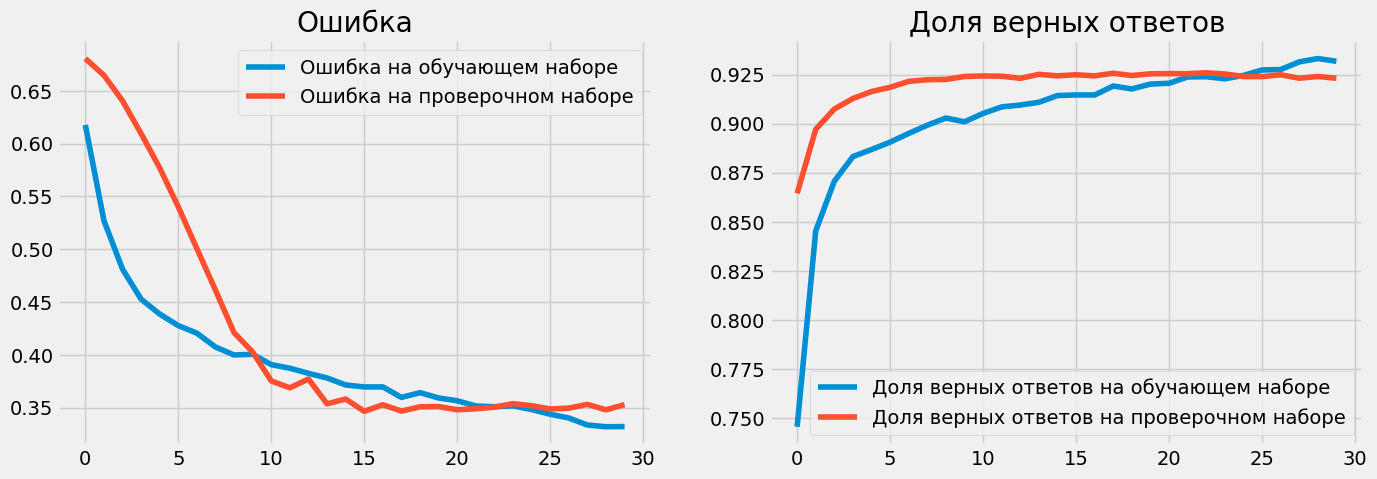

In [ ]:
model = create_model(X1_train.shape[1])
#utils.plot_model(model, show_shapes=True)
e_stop = EarlyStopping(monitor='val_auc', patience=20)
save_best_w = ModelCheckpoint(filepath='./', save_weights_only=True, monitor='val_auc', mode='max', save_best_only=True)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['AUC'])
history1 = model.fit(X1_train, y1_train,
                     validation_data=[X1_val, y1_val],
                     batch_size=64, epochs=30, verbose=1, shuffle=True,
                     class_weight={0:class_weights[0],1:class_weights[1]},
                     callbacks = [e_stop, save_best_w]
                     )
model.load_weights('./')
# with open('model.pickle', 'rb') as fp:
#         tokenizer, model = pickle.load(fp)
pred_test = model.predict(X1_test)
auc = roc_auc_score(y1_test,pred_test)
print(f'Точность на тестовой выборке по метрике roc_auc: {auc:5.3f}')
threshold = 0.5
y_pred_binary = (pred_test > threshold).astype(int)
print(classification_report(y1_test,y_pred_binary))
plot_history(history1,'loss','auc')

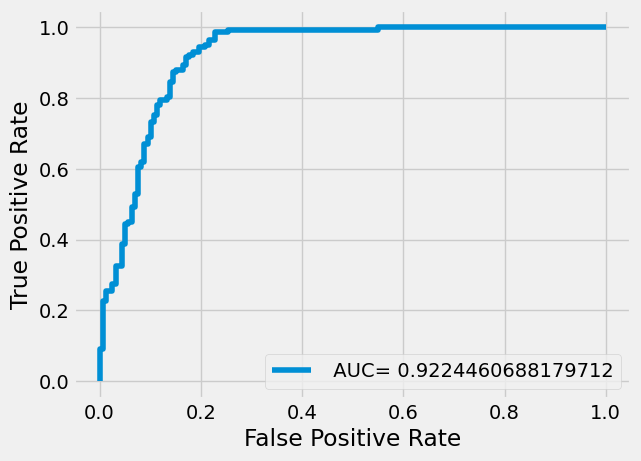

In [ ]:
fpr, tpr, _ = roc_curve(y1_test, pred_test)

#create ROC curve
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

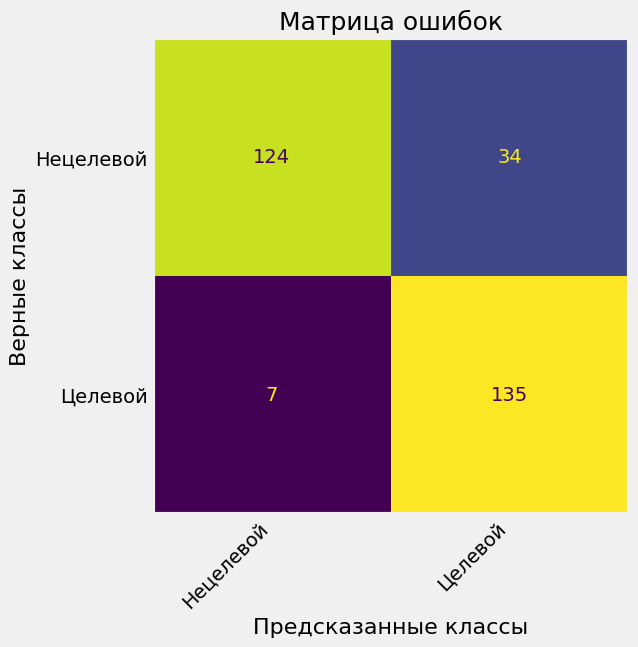

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
# Построение матрицы ошибок
cm = confusion_matrix(y1_test, y_pred_binary)

# Отрисовка матрицы ошибок
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title(f'Матрица ошибок', fontsize=18)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Нецелевой','Целевой'])
disp.plot(ax=ax)
plt.style.use('fivethirtyeight')
plt.grid(None)
plt.gca().images[-1].colorbar.remove()
plt.xlabel('Предсказанные классы', fontsize=16)
plt.ylabel('Верные классы', fontsize=16)
fig.autofmt_xdate(rotation=45)
plt.show()

In [ ]:
# Сохранение модели в файл, для чтения используется pickle.dump()
with open(f_dir+'model.pkl', 'wb') as f:
    pickle.dump([model], f)

# Функция предсказания

In [ ]:
# whisper
! pip install git+https://github.com/openai/whisper.git
! sudo apt update && sudo apt install ffmpeg
# BERT
! pip install transformers sentencepiece

In [11]:
import os
import re
import whisper
import time
import torch
from transformers import AutoTokenizer, AutoModel
import tensorflow as tf
from tensorflow.keras.models import load_model
import pandas as pd  # для работы с таблицами
import numpy  as np  # для работы с массивами


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# whisper_model = 'tiny' # Very fast and very inaccurate speech recognition
# whisper_model = 'base' # Fast and fourius
# whisper_model = 'small' # Worse than medium but still OK
# whisper_model = 'medium' # Good recognition results but too slow on CPU
whisper_model = 'large' # Use on GPU only
text_language = 'ru'
model_w = whisper.load_model(whisper_model)

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model_bert = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model_bert.cuda()  # uncomment it if you have a GPU
f_dir = '/content/drive/MyDrive/Traineeships/media108/'
#f_dir = 'c:/Users/vokulovskiy/Documents/python/media108/'


100%|█████████████████████████████████████| 2.88G/2.88G [00:45<00:00, 68.6MiB/s]


In [8]:
model_nn = load_model(f_dir+'model.h5')

In [13]:
def predict_mp3(song_file):
    result = model_w.transcribe(song_file, verbose = True, language = text_language)
    rawtext = ' '.join([segment['text'].strip() for segment in result['segments']])
    rawtext = re.sub(" +", " ", rawtext)
    alltext = re.sub("([\.\!\?]) ", "\\1\n", rawtext)
    #Удаляем из Текст_whisper все символы кроме русских букв и цифр
    alltext = re.sub("[^А-Яа-я0-9 ]", "", alltext.lower()).strip()

    t = tokenizer(alltext, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model_bert(**{k: v.to(model_bert.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    X = embeddings[0].cpu().numpy()
    return model_nn.predict(X.reshape(1,X.shape[0]))

In [17]:
dfs = pd.read_csv(f_dir+'df_all.csv',encoding='cp1251')
vib = dfs.loc[:,['Name','Имя файла','Признак','Теги']].sample(1)
decode_dir = {'Павелецкая сити':'Записи звонков_павелецкая сити', 'Headliner':'Записи звонков_хедлайнер', 'Примавера':'Записи звонков_primavera'}

for i,row in vib.iterrows():
    fname = '/content/drive/MyDrive/Traineeships/media108/audio/'+ row['Имя файла']
    print(fname)
    try:
        file = open(fname)
    except IOError as e:
        print(u'не удалось открыть файл')
    else:
        file.close()
        v = predict_mp3(fname)
        print(f"Файл: {row['Имя файла']}, признак:{row['Признак']}, тег: {row['Теги']}")
        print(f'\tВероятность целевого звонка: {v[0][0]:5.3f}')



/content/drive/MyDrive/Traineeships/media108/audio/Записи звонков_хедлайнер/2023-07-04_12-23-35.372384_from_79265459973_to_74959339902_session_3075699925_talk.mp3
[00:00.000 --> 00:07.900]  Здравствуйте. Вы позвонили в группу компании «Картрос». Благодарим вас за звонок. Пожалуйста, дождитесь ответа оператора.
[00:19.740 --> 00:22.420]  Добрый день. Группа компании «Картрос». Меня зовут Любовь.
[00:22.420 --> 00:33.840]  Добрый день. На линии Вячеслав. Интересует хедлайнер. Бюджет не ограничен. Четырехкомнатная квартира, террасы, верхние этажи. Могу соединить?
[00:34.280 --> 00:35.040]  Да, спасибо.
[00:36.660 --> 00:40.080]  Добрый день. Жилой комплекс «Хедлайнер». Соединяется делом продаж.
[00:41.300 --> 00:41.680]  Да.
[00:52.420 --> 01:22.400]  Добрый день. Жилой комплекс «Хедлайнер». Соединяется делом продаж.
[01:22.420 --> 01:25.880]  Почему вы смотрите? Потому что у нас террасы невысокие, невысотные дома.
[01:28.140 --> 01:29.700]  Нет, невысокие дома.
[01:32.600 --> 01:42.560] 